# USA weekly (between Wednesdays) COVID-19 predictions

> This notebook implements a neural network model that predicts how many new US COVID-19 cases will be confirmed in between the last passed Wednesday and the upcoming Wednesday. It trains using historical US flu data from 1997-2019, and tests on currently available US COVID-19 cases data reported by Johns Hopkins University.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing

### getting historical flu data

In [2]:
flu_dir = "../../cdc-fludata/us_national/"

In [3]:
flu_dictionary = {}

for year in range(1997, 2019):
    filepath = "usflu_"
    year_string = str(year) + "-" + str(year + 1)
    filepath = flu_dir + filepath + year_string + ".csv"
    temp_df = pd.read_csv(filepath)
    flu_dictionary[year] = temp_df

### combining flu data into one chronological series of total cases

In [4]:
# getting total cases and putting them in a series by week
flu_series_dict = {} 

for year in flu_dictionary:
    temp_df = flu_dictionary[year]
    temp_df = temp_df.set_index("WEEK")
    abridged_df = temp_df.iloc[:, 2:]
    
    try:
        abridged_df = abridged_df.drop(columns="PERCENT POSITIVE")
    except:
        pass
    
    total_cases_series = abridged_df.sum(axis=1)
    flu_series_dict[year] = total_cases_series
    

In [5]:
all_cases_series = pd.Series(dtype="int64")

for year in flu_series_dict:
    temp_series = flu_series_dict[year]
    all_cases_series = all_cases_series.append(temp_series, ignore_index=True)

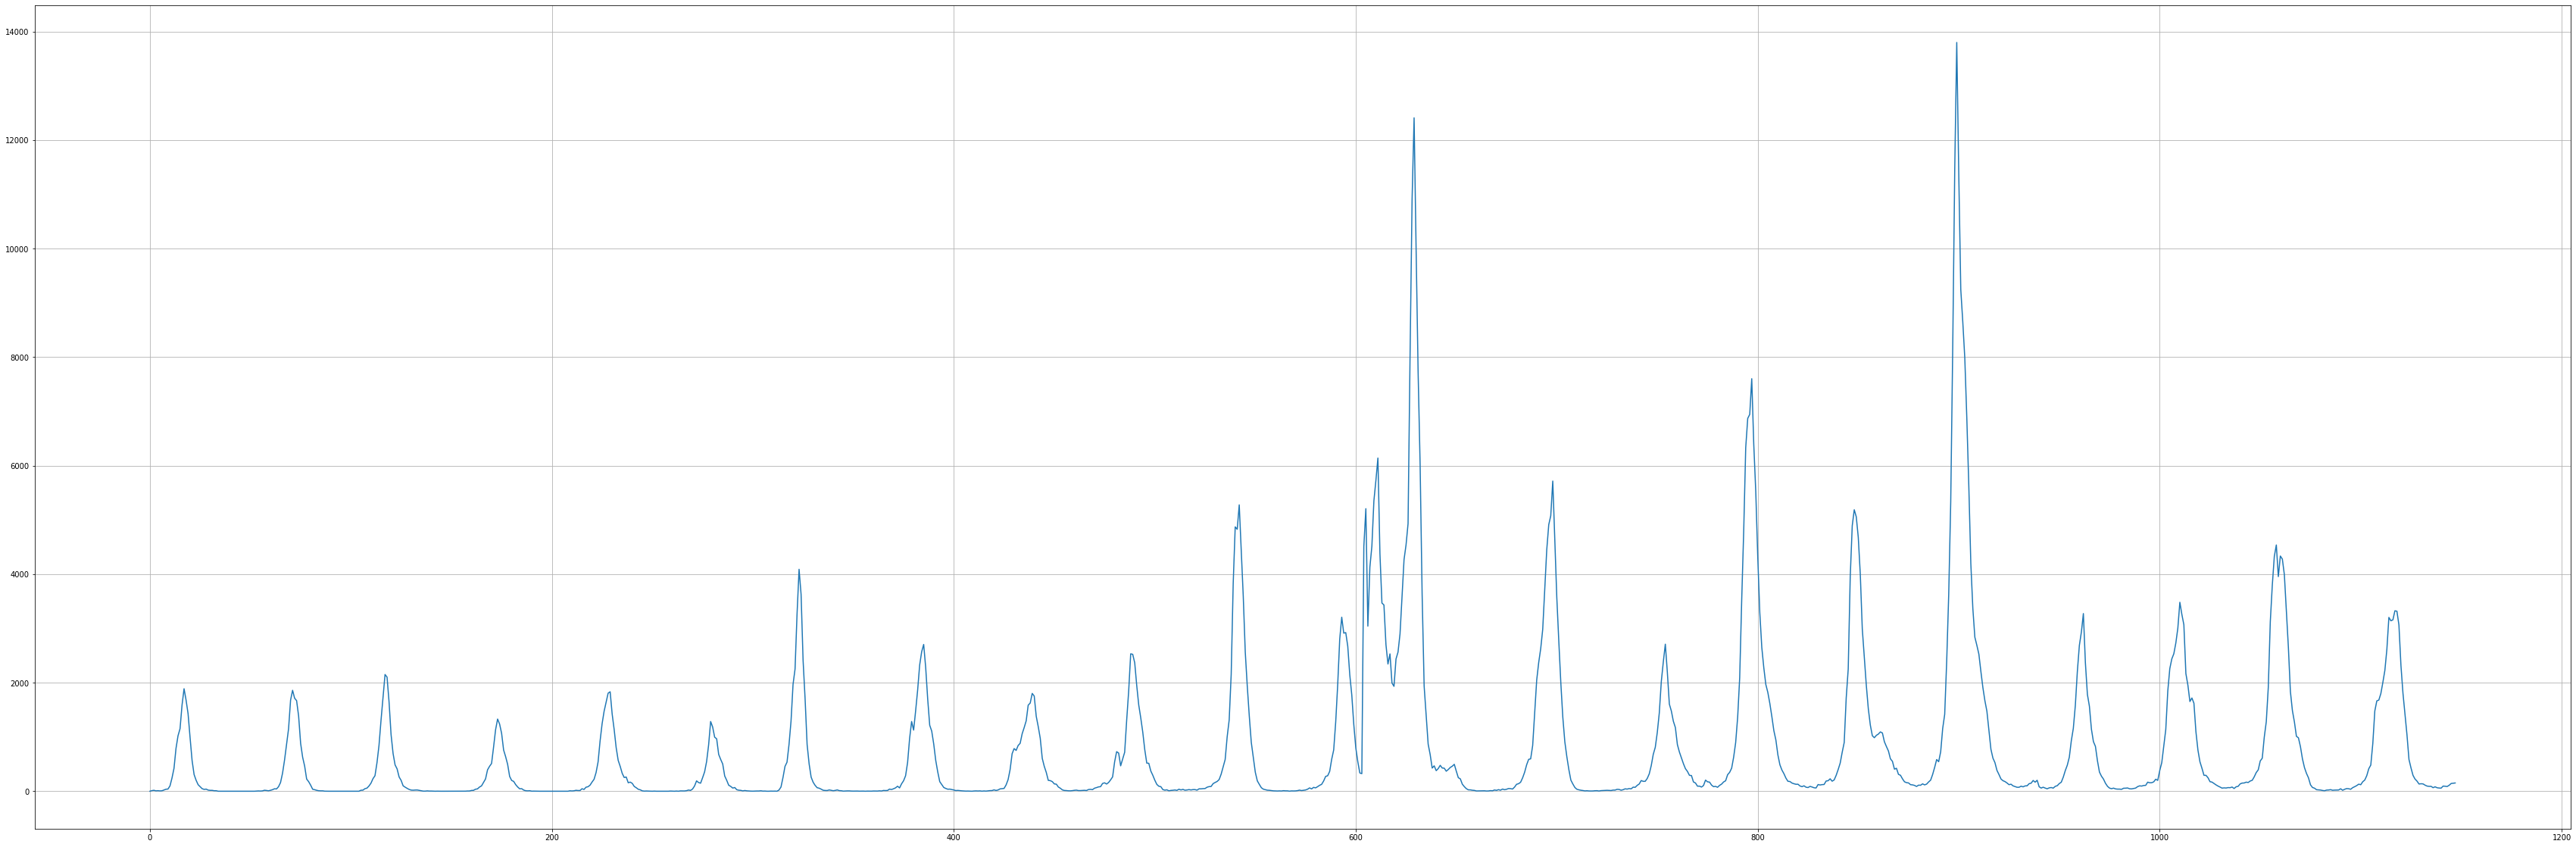

In [6]:
all_cases_series.plot(grid=True, figsize=(60,20))

### Now, making a normalized series between 0, 1

In [7]:
norm_flu_series_dict = {}

for year in flu_series_dict:
    temp_series = flu_series_dict[year]
    temp_list = preprocessing.minmax_scale(temp_series)
    temp_series = pd.Series(temp_list)
    norm_flu_series_dict[year] = temp_series

In [8]:
all_cases_norm_series = pd.Series(dtype="int64")

for year in norm_flu_series_dict:
    temp_series = norm_flu_series_dict[year]
    all_cases_norm_series = all_cases_norm_series.append(temp_series, ignore_index=True)

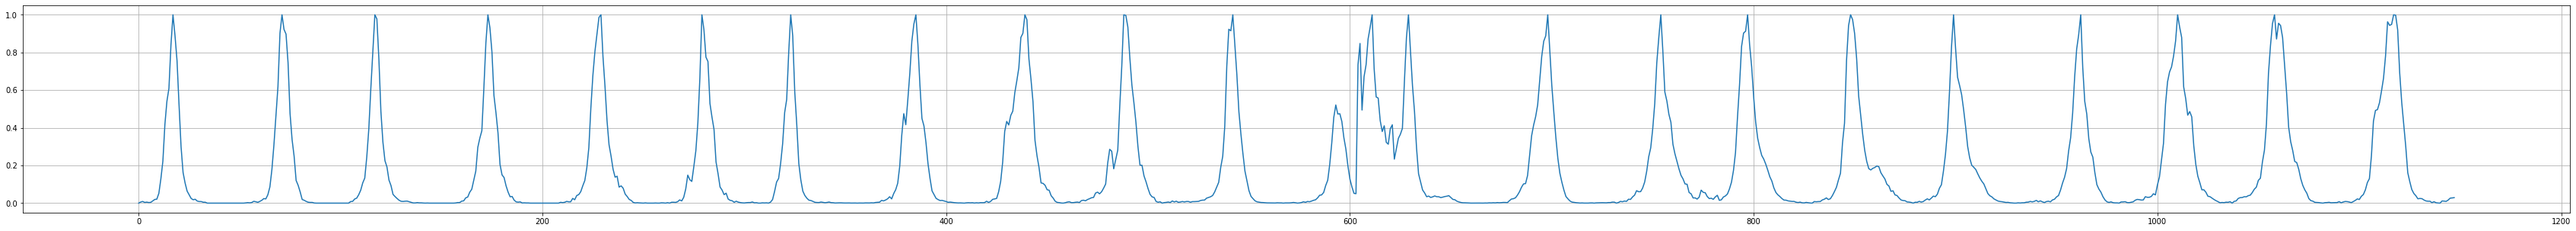

In [9]:
all_cases_norm_series.plot(grid=True, figsize=(60,5))

## Getting US COVID-19 Case Data

In [10]:
datapath = "../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

# Choose from "US Cases", "US Deaths", "World Cases", "World Deaths", "World Recoveries"
key = "World Cases" 

if key == "US Cases":
    datapath = datapath + "time_series_covid19_confirmed_US.csv"
elif key == "US Deaths":
    datapath = datapath + "time_series_covid19_deaths_US.csv"
elif key == "World Cases":
    datapath = datapath + "time_series_covid19_confirmed_global.csv"
elif key == "World Deaths":
    datapath = datapath + "time_series_covid19_deaths_global.csv"
elif key == "World Recoveries":
    datapath = datapath + "time_series_covid19_recovered_global.csv"

In [11]:
covid_df = pd.read_csv(datapath)

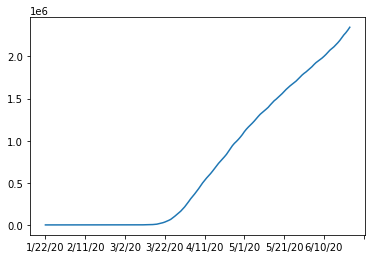

In [12]:
us_data = covid_df.loc[covid_df["Country/Region"] == "US"]
us_cases = us_data.iloc[:,4:]
us_cases = us_cases.squeeze()
us_cases.plot()

### convert daily data to weekly data

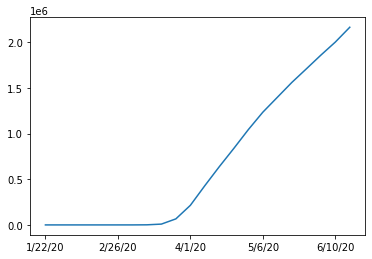

In [17]:
us_weekly_cases = us_cases.iloc[::7]
us_weekly_cases.plot()

In [37]:
# getting appropriate dates for final prediction

final_date = us_weekly_cases.index[-1]
final_date_elements = final_date.split('/')
final_date_elements

['6', '17', '20']

### Converting cumulative series to non-cumulative series

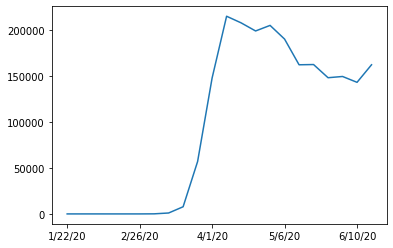

In [18]:
us_wnew_cases = us_weekly_cases.diff()
us_wnew_cases[0] = 1.0
us_wnew_cases.plot()

### normalizing weekly case data

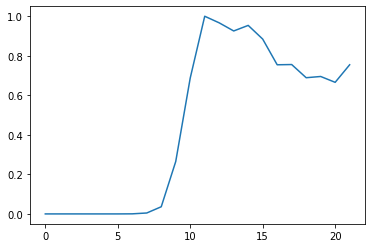

In [19]:
temp_list = sklearn.preprocessing.minmax_scale(us_wnew_cases)
us_wnew_cases_norm = pd.Series(temp_list)
us_wnew_cases_norm.plot()

## Building Neural Net Model

### Setting Testing & Training Data

In [20]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [21]:
flu_data_train = all_cases_norm_series.to_numpy().flatten()
covid_data_test = us_wnew_cases_norm.to_numpy().flatten()

In [22]:
# choose {covid_past_history} vals to use to predict {covid_future_target + 1} vals into the future
past_history = len(us_wnew_cases_norm)
future_target = 0

x_train_us, y_train_us = univariate_data(flu_data_train, 
                                         0, 
                                         None, 
                                         past_history, 
                                         future_target)

In [23]:
print(x_train_us.shape, y_train_us.shape)
print(x_train_us.shape[-2:])

(1126, 22, 1) (1126,)
(22, 1)


Past history example:
 [[0.0083682 ]
 [0.009298  ]
 [0.0218503 ]
 [0.0264993 ]
 [0.0446304 ]
 [0.06880521]
 [0.10739191]
 [0.13296141]
 [0.24500232]
 [0.39284054]
 [0.60715946]
 [0.80241748]
 [1.        ]
 [0.9776848 ]
 [0.76476058]
 [0.48535565]
 [0.32310553]
 [0.22547652]
 [0.19153882]
 [0.12226871]
 [0.09298001]
 [0.04649   ]]
using this history to predict the val:  0.03486750348675035


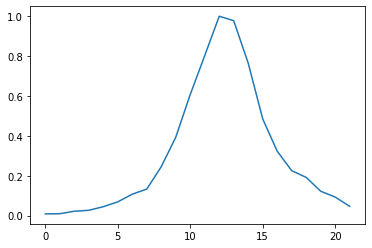

In [24]:
index = 105
print("Past history example:\n", x_train_us[index])
print("using this history to predict the val: ", y_train_us[index])
plt.plot(x_train_us[index])

### Designing Model Implementation

In [25]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = 300
BUFFER_SIZE = 10000

train_us = tf.data.Dataset.from_tensor_slices((x_train_us, y_train_us))
train_us = train_us.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [26]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_us.shape[-2:]),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

In [27]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [28]:
lstm_prediction_model.fit(train_us, epochs=10, steps_per_epoch=250)

Train for 250 steps
Epoch 1/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0548
Epoch 2/10
250/250 [==============================] - 16s 63ms/step - loss: 0.0252
Epoch 3/10
250/250 [==============================] - 16s 63ms/step - loss: 0.0243
Epoch 4/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0237
Epoch 5/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0236
Epoch 6/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0235
Epoch 7/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0234
Epoch 8/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0232
Epoch 9/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0231
Epoch 10/10
250/250 [==============================] - 16s 64ms/step - loss: 0.0229


In [29]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

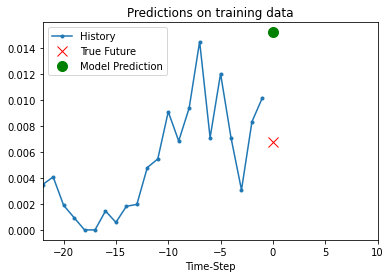

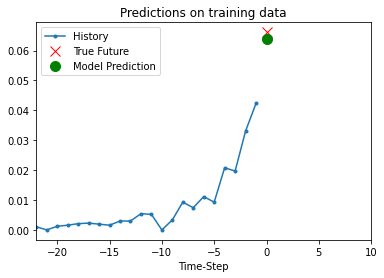

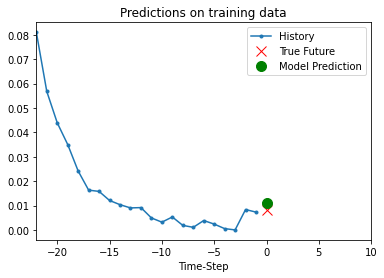

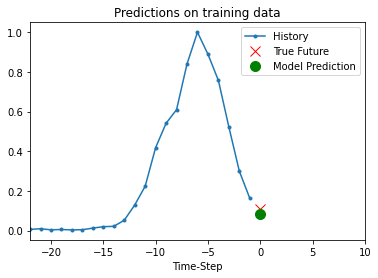

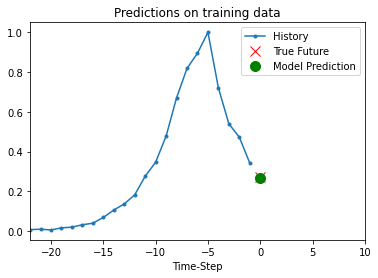

In [30]:
for x, y in train_us.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Predictions on training data')
  plot.show()

## finally, the prediction of new cases in between last Wednesday and upcoming Wednesday

In [31]:
covid_data_test = np.append(covid_data_test, 1)

x_val_us, y_val_us = univariate_data(covid_data_test, 
                                     0, 
                                     None, 
                                     past_history, 
                                     future_target)

val_us = tf.data.Dataset.from_tensor_slices((x_val_us, y_val_us))
val_us = val_us.batch(1).repeat()

In [32]:
def show_prediction(plot_data, delta, title):
  labels = ['History', 'Model Prediction']
  marker = ['.-', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  future = delta

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Week (defined by Wednesdays; 0 is next week/Wednesday)')
  plt.ylabel('New Cases')
  return plt

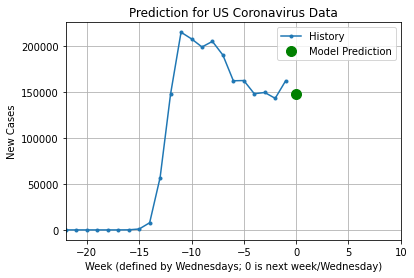

According to model prediction, 
there will be 148292 new COVID-19 cases in the US, 
in between this past Wednesday and this upcoming Wednesday.


In [33]:
for x, y in val_us.take(1):
  predicted_cases = lstm_prediction_model.predict(x)[0] * us_wnew_cases.max()
  plot = show_prediction([x[0].numpy() * us_wnew_cases.max(),
                    predicted_cases], 0, 'Prediction for US Coronavirus Data')
  plot.show()
  print("According to model prediction, ")
  print("there will be {} new COVID-19 cases in the US, ".format(int(predicted_cases)))
  print("in between this past Wednesday and this upcoming Wednesday.")